## Chapter 9 : RNN
- Two form of sequence to sequence task:
  - **aligned**: input at certain time step aligns with corrsponding output, like tagging (fight -> verb)
  - **unaligned**: no step-to-step correspondence, like maching translation
- **Autoregressive** model: regress value based on previous value
  - latent autoregressive models (since $h_t$ is never observed): estimate $P(x_t | x_{t-1} \dots x_1)$ with $\hat x_t = P(x_t | h_t)$ and $h_t = g(h_{t-1}, x_{t-1})$
- **Sequence Model**: to get joint probablity of a sequence $p(x_1, \dots, x_T)$, we change it to a form like autoregressive one: $p(x_1) \prod_{t=2}^T p(x_t|x_{t-1}, \dots, x_1)$
  - **Markov Condition**: if we can make the condition above into $x_{t-1}, \dots, x_{t-\tau}$ without any loss, aka the future is conditionally independent of the past, given the recent history, then the sequence satisfies a Markov condition. And it is $\tau^{th}$-order Markov model.
- Zipf’s law: the frequency of words will decrease exponentially, n-grams too (with smaller slope).
  - So use word frequency to construct the probility is not good, for example. $\hat p(learning|deep) = n(deep, learning) / n(deep)$, $n(deep, learning)$ will be very small compared to denominator. We can use so called **Laplace Smooth** but that will not help too much.
- **Perplexity**: (how confusion it is), given a true test data, the cross-entropy is $J = \frac{1}{n} \sum_{t=1}^n -\log P(x_t | x_{t-1}, \dots, x_1)$, and the perplexity is $\exp(J)$.
- Partioning the sequence: for a $T$ token indices sequence, we add some randomness, discard first $d \in U(0, n]$ tokens and partion the rest into $m = \lfloor (T-d) / n \rfloor$ group. For a sequence $x_t$ the target sequence is shifted by one token $x_{t+1}$.
---
- **RNN**: for a vocab with size $|\mathcal V|$, the model parameters should go up to $|\mathcal V|^n$, $n$ is the sequence length.So we $P(x_t | x_{t-1} \dots x_1) \approx P(x_t | h_{t-1})$，$h$ is a **hidden state**, it varies at different time step and contains information of previous time steps. Hidden layer, on the other hand, is a structure, it dose not change in forward calculation.
  - recurrent: $H_t = \phi (X_tW_{th} + H_{t-1}W_{hh} + b_h)$, output is $O_t = H_tW_{tq} + b_q$.
  - <img alt="ResNeXt Block" src="https://d2l.ai/_images/rnn.svg" style="background-color: white; display: inline-block;">
       RNN Block
  - clip the gradient: $g = \min(1, \frac{\theta}{|| g ||}) g$, it is a hack but useful.
  - **Warm-up**: When predicting, we can first feed a prefix (now called prompt I think), just iter the prefix into the network without generating output until we need to predict.
- For RNN: the input shape is (sequence_length, batch_size, feature_size), first is time_step, third is one-hot dim or word2vec dim.
- **Backpropagation through time**
  - <img alt="ResNeXt Block" src="https://d2l.ai/_images/rnn-bptt.svg" style="background-color: white; display: inline-block;"> Computation graph of RNN
  - How to reduce gradient explosion or vanishing: truncate the gradient propagete at certain time step.
  - In the img above: $\frac{\partial L}{\partial h_T} = W_{qh}^{\intercal} \frac{\partial L}{\partial o_T}$, $\frac{\partial L}{\partial h_t} = \sum_{i=t}^T (W_{hh}^{\intercal})^{T-i} W_{qh}^{\intercal} \frac{\partial L}{\partial o_{T+t-i}}$, $\frac{\partial L}{\partial W_{hx}} = \sum_{t=1}^T \frac{\partial L}{\partial h_t} x_t^{\intercal}$, $\frac{\partial L}{\partial W_{hh}} = \sum_{t=1}^T \frac{\partial L}{\partial h_t} h_{t-1}^{\intercal}$.

In [1]:
import torch
import re
from torch import nn
import torch.nn.functional as F

In [14]:
import collections
import inspect
from IPython import display
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
  
def tokenization(data):
    tokens = list(data)
    return tokens

class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

class TimeMachine(DataModule):
    def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
        super().__init__()
        self.save_hyperparameters()
        corpus, self.vocab = self.build(self.get_data())
        array = torch.tensor([corpus[i:i+num_steps+1]
                            for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:,:-1], array[:,1:]

    def build(self, data):
        tokens = tokenization(data)
        vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

    def get_data(self):
        with open("../../Data/TimeMachine.txt") as f:
            data = f.read()
            data = re.sub('[^A-Za-z]+', ' ', data).lower()
        return data

    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(
            self.num_train, self.num_train + self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)

In [28]:
with open("../../Data/TimeMachine.txt") as f:
    data = f.read()
    data = re.sub('[^A-Za-z]+', ' ', data).lower() # Only letters and space
data[:100]

'the time machine by h g wells i the time traveller for so it will be convenient to speak of him was '

In [29]:
'''Tokenize it with letters'''
tokens = tokenization(data)
vocab = Vocab(tokens)
corpus = [vocab[token] for token in tokens]
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))
print(len(vocab), len(corpus)) # 26 letters, space and an unknow token

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']
28 173428


In [14]:
'''Tokenize it with words'''
words = data.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

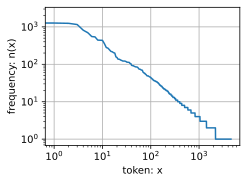

In [26]:
freqs = [freq for token, freq in vocab.token_freqs]
plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

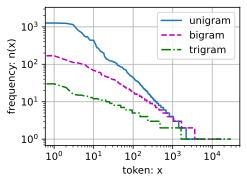

In [27]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

In [8]:
time_machine = TimeMachine(2, 10)

In [30]:
for X, Y in time_machine.train_dataloader():
    print('X:', X, '\nY:', Y)
    print('X:', X.shape, ', Y:', Y.shape)
    batch = [a for a in X]
    print("*batch[:-1], batch[-1]", *batch[:-1], batch[-1])
    print('words:', vocab.to_tokens(*batch[:-1]), vocab.to_tokens(batch[-1]))
    break

X: tensor([[21, 16,  0, 21,  6, 13, 13,  0, 22, 20],
        [ 6, 15,  0,  2, 21,  0,  3, 22, 19, 20]]) 
Y: tensor([[16,  0, 21,  6, 13, 13,  0, 22, 20,  0],
        [15,  0,  2, 21,  0,  3, 22, 19, 20, 13]])
X: torch.Size([2, 10]) , Y: torch.Size([2, 10])
*batch[:-1], batch[-1] tensor([21, 16,  0, 21,  6, 13, 13,  0, 22, 20]) tensor([ 6, 15,  0,  2, 21,  0,  3, 22, 19, 20])
words: ['t', 'o', ' ', 't', 'e', 'l', 'l', ' ', 'u', 's'] ['e', 'n', ' ', 'a', 't', ' ', 'b', 'u', 'r', 's']


In [62]:
'''RNN from scratch'''
                
class RNNScratch(nn.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros((inputs.shape[1], self.num_hiddens),
                              device=inputs.device)
        else:
            state, = state
        outputs = []
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
            state = torch.tanh(torch.matmul(X, self.W_xh) +
                             torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state
        
class RNNLMScratch(Classifier):
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(batch[0]), batch[-1]) 
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def forward(self, X, state=None): # output is (batch_size, num_steps, vocab_size)
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)

    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

In [56]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 28, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)
print(outputs[0].shape)
print(state.shape)

torch.Size([2, 32])
torch.Size([2, 32])


In [57]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
# model.layer_summary((batch_size, num_steps))

In [58]:
print(outputs.shape)

torch.Size([2, 100, 28])


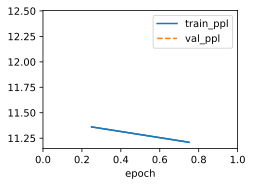

In [44]:
rnn = RNNScratch(num_inputs=len(time_machine.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(time_machine.vocab), lr=1)
trainer = Trainer(max_epochs=1, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, time_machine)

In [64]:
'''Concise RNN Impl'''
class RNN(Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

class RNNLM(RNNLMScratch):  #@save
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

In [67]:
data = TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
print(len(data.vocab))
model.predict('it has', 20, data.vocab)

28
torch.Size([2, 100, 28])


'it hasffffffffffffffffffff'

In [76]:
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
print(outputs.shape)

torch.Size([2, 100, 28])


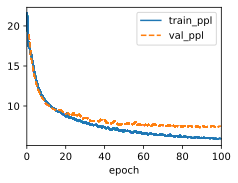

In [68]:
trainer = Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [77]:
model.cpu().predict('the time machine by', 200, data.vocab)

'the time machine by the time toung the time toung the time toung the time toung the time toung the time toung the time toung the time toung the time toung the time toung the time toung the time toung the time toung the '

In [3]:
class HyperParameters:
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        """Defined in :numref:`sec_oo-design`"""
        raise NotImplemented

    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes.
    
        Defined in :numref:`sec_utils`"""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

class DataModule(HyperParameters):
    """The base class of data.

    Defined in :numref:`subsec_oo-design-models`"""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        """Defined in :numref:`sec_synthetic-regression-data`"""
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size,
                                           shuffle=train)
        
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib.

    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points.

    Defined in :numref:`sec_calculus`"""

    def has_one_axis(X):  # True if X (tensor or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X): X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)

    set_figsize(figsize)
    if axes is None:
        axes = plt.gca()
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x,y,fmt) if len(x) else axes.plot(y,fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

class ProgressBoard(HyperParameters):
    """The board that plots data points in animation.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        use_svg_display()
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)

In [5]:
class Module(nn.Module, HyperParameters):
    """The base class of models.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.detach().cpu().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

    def configure_optimizers(self):
        """Defined in :numref:`sec_classification`"""
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def apply_init(self, inputs, init=None):
        """Defined in :numref:`sec_lazy_init`"""
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)
            
class Classifier(Module):
    """The base class of classification models.

    Defined in :numref:`sec_classification`"""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions.
    
        Defined in :numref:`sec_classification`"""
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = torch.astype(torch.argmax(Y_hat, axis=1), Y.dtype)
        compare = torch.astype(preds == torch.reshape(Y, -1), torch.float32)
        return torch.reduce_mean(compare) if averaged else compare

    def loss(self, Y_hat, Y, averaged=True):
        """Defined in :numref:`sec_softmax_concise`"""
        Y_hat = torch.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = torch.reshape(Y, (-1,))
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

    def layer_summary(self, X_shape):
        """Defined in :numref:`sec_lenet`"""
        X = torch.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [33]:
class Trainer(HyperParameters):
    """The base class for training models with data.

    Defined in :numref:`subsec_oo-design-models`"""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

    def prepare_batch(self, batch):
        """Defined in :numref:`sec_linear_scratch`"""
        return batch

    def fit_epoch(self):
        """Defined in :numref:`sec_linear_scratch`"""
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            loss.backward()
            with torch.no_grad():
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        """Defined in :numref:`sec_use_gpu`"""
        self.save_hyperparameters()
        self.gpus = [torch.device(f'cuda:{i}') for i in range(min(num_gpus, torch.cuda.device_count()))]
    

    def prepare_batch(self, batch):
        """Defined in :numref:`sec_use_gpu`"""
        if self.gpus:
            batch = [a.to(self.gpus[0]) for a in batch]
            # batch = batch.to(self.gpus[0])
        return batch
    

    def prepare_model(self, model):
        """Defined in :numref:`sec_use_gpu`"""
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model

    def clip_gradients(self, grad_clip_val, model):
        """Defined in :numref:`sec_rnn-scratch`"""
        params = [p for p in model.parameters() if p.requires_grad]
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm